**Due to the fact that the feature selection of kNN is not relevant to correlation, <br/> a separate data transformation and variable subset selection is performed.**

In [2]:
library(dplyr)
library(tidyverse)
library(magrittr)
library(ggplot2)
library(randomForest)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ stringr 1.4.0
✔ tidyr   1.1.3     ✔ forcats 0.5.1
✔ readr   2.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine




In [3]:
# 1.1 Data processing, wrangling, transformation
# Original dataset import 
star_original <- read.csv("/Users/apple/Desktop/LastTerm_UBC_2022_W2/STAT447B/GroupProject/Rdata/star_classification.csv",header=T)

**Same pre-process as in PhaseA**

In [4]:
# prune extreme value
star_original <- star_original[-79544, ]

In [5]:
#1.1-3. Transform variables if necessary in order to do plots
# cos transformation on variables w/ unit as angle
# Scaling all numeric variables, then trunk at 5 digits
# categorical variables to factor
star <- star_original %>% mutate(  
  alpha = cos(alpha),
  delta = cos(delta),
  obj_ID = round(scale(obj_ID, center = TRUE, scale = TRUE), 5),
  u = round(scale(u, center = TRUE, scale = TRUE), 5),
  g = round(scale(g, center = TRUE, scale = TRUE), 5),
  r = round(scale(r, center = TRUE, scale = TRUE), 5),
  i = round(scale(i, center = TRUE, scale = TRUE), 5),
  z = round(scale(z, center = TRUE, scale = TRUE), 5),
  run_ID = round(scale(run_ID, center = TRUE, scale = TRUE), 5),
  spec_obj_ID = round(scale(spec_obj_ID, center = TRUE, scale = TRUE), 5),
  redshift = round(scale(redshift, center = TRUE, scale = TRUE), 5),
  field_ID = round(scale(field_ID, center = TRUE, scale = TRUE), 5),
  plate = round(scale(plate, center = TRUE, scale = TRUE), 5),
  MJD = round(scale(MJD, center = TRUE, scale = TRUE), 5),
  fiber_ID = round(scale(fiber_ID, center = TRUE, scale = TRUE), 5),
  cam_col = factor(cam_col),
  class = factor(class),
  
)

In [7]:
#create variable breaks
field_id_breaks <- c(-1.18, -0.774, -0.45, -0.06, 0.58, 5.4)
run_id_breaks <- c(-2.23, -0.831, -0.327, 0.048, 0.8, 1.9)

# combining
breaks <- rbind(field_id_breaks, run_id_breaks)

#binning function
bin <- function(dataset, breaks) {
  bindata <- as_tibble(dataset) %>%
    dplyr::mutate(fieldbin = cut(field_ID, breaks[1,]),
                  runbin = cut(run_ID, breaks[2,])) %>%
    dplyr::select(class, field_ID, run_ID, fieldbin, runbin)
  bindata
}
# apply function
bin_result <- bin(star, breaks)
summary(bin_result)

    class          field_ID.V1          run_ID.V1                 fieldbin    
 GALAXY:59445   Min.   :-1.17529   Min.   :-2.2254400   (-1.18,-0.774]:20181  
 QSO   :18961   1st Qu.:-0.69880   1st Qu.:-0.6588200   (-0.774,-0.45]:19832  
 STAR  :21593   Median :-0.26929   Median :-0.1493300   (-0.45,-0.06] :19963  
                Mean   : 0.00000   Mean   :-0.0000002   (-0.06,0.58]  :20097  
                3rd Qu.: 0.36826   3rd Qu.: 0.4298800   (0.58,5.4]    :19926  
                Max.   : 5.38813   Max.   : 1.8733300                         
             runbin     
 (-2.23,-0.831] :20019  
 (-0.831,-0.327]:19590  
 (-0.327,0.048] :20341  
 (0.048,0.8]    :20116  
 (0.8,1.9]      :19933  
                        

In [8]:
#combined binning result to dataset as separate variables, and change type to factor
star <- cbind(star, bin_result[, 4:5])
star <- star %>%
  mutate(fieldbin = factor(star$fieldbin), runbin = factor(star$runbin))

In [9]:
# re-order dataset by putting categorical variable and response variable to last
# rerun_ID should be dropped since it only has same value for all observations
# field_ID and run_ID should be replaced by their bins

star <- star[, c(1:9, 13, 15:18, 11,19,20, 14)]

In [10]:
# pick a subset
set.seed(447)
n <- star %>% nrow()
star_subset <- sample_n(star, size = n * 0.1)

### Feature Selection Using Random Forest

since kNN does not support feature selection natively, RF and Permutation is used instead.

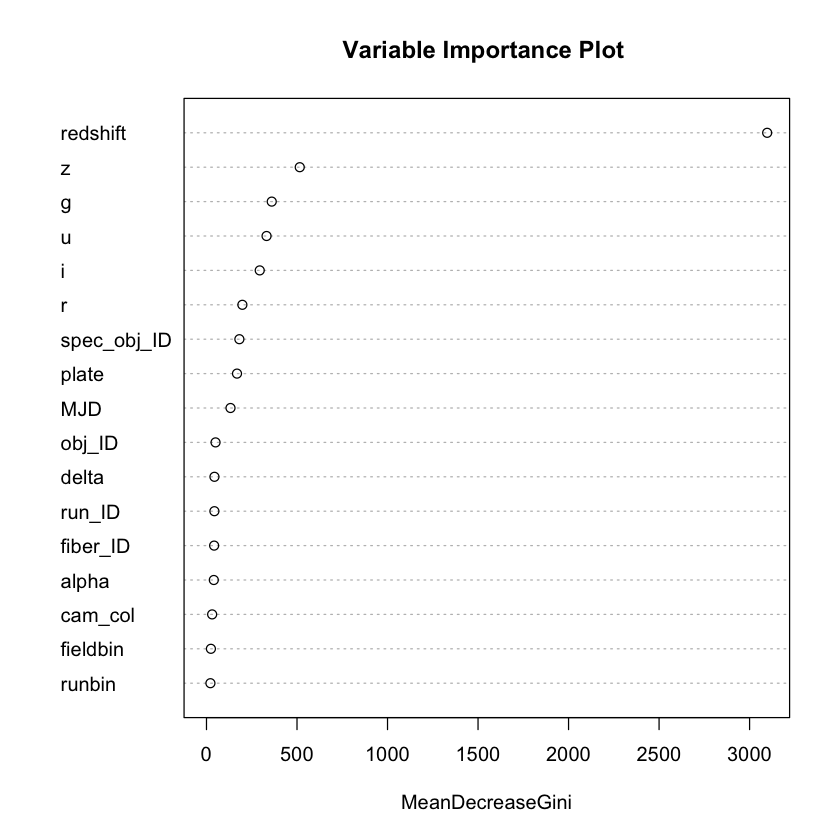

In [14]:
# applying rf on subset 
rf <- randomForest(factor(class) ~ ., data = star_subset)
varImpPlot(rf, main = "Variable Importance Plot ")

**redshift, z, g, u, i, r, spec_obj_ID, Plate, and MJD **

In [15]:
# **redshift, z, g, u, i, r, spec_obj_ID, Plate, and MJD **
kNN_star_rf <- star[, c(11, 4:8, 10, 12, 13, 18 )]
kNN_star_subset_rf <- star_subset[, c(11, 4:8, 10, 12, 13, 18 )]

In [16]:
# save kNN transformation by RF dataset to csvs
write.csv(kNN_star_rf,'/Users/apple/Desktop/LastTerm_UBC_2022_W2/STAT447B/GroupProject/kNN_data/kNN_PhaseA_star_rf.csv')
write.csv(kNN_star_subset_rf,'/Users/apple/Desktop/LastTerm_UBC_2022_W2/STAT447B/GroupProject/kNN_data/kNN_PhaseA_star_subset_rf.csv')

### Result from Python Permutation Feature Importance

In [17]:
star %>% colnames()

[1] "obj_ID"      "alpha"       "delta"       "u"           "g"          
 [6] "r"           "i"           "z"           "run_ID"      "spec_obj_ID"
[11] "redshift"    "plate"       "MJD"         "fiber_ID"    "cam_col"    
[16] "fieldbin"    "runbin"      "class"

**u, g, z, redshift, MJD, camcol, fieldbin and runbin**

In [18]:
kNN_star_perm<- star[,c(4, 5, 8, 11, 13, 15, 16, 17, 18)]

In [19]:
# pick a subset
set.seed(447)
n <- kNN_star_perm %>% nrow()
kNN_star_subset_perm <- sample_n(kNN_star_perm, size = n * 0.1)

In [20]:
write.csv(kNN_star_perm,'/Users/apple/Desktop/LastTerm_UBC_2022_W2/STAT447B/GroupProject/kNN_data/kNN_PhaseA_star_perm.csv')
write.csv(kNN_star_subset_perm,'/Users/apple/Desktop/LastTerm_UBC_2022_W2/STAT447B/GroupProject/kNN_data/kNN_PhaseA_star_subset_perm.csv')